# Utilities

In [29]:
from sklearn.neighbors import KNeighborsClassifier
from skimage import transform
from skimage.transform import rotate, AffineTransform,warp
from skimage import util
from skimage.filters import gaussian
from sklearn import preprocessing
import numpy as np



import cv2
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt


In [30]:
def showImage(image):
    plt.imshow(image, cmap = matplotlib.cm.binary, interpolation='nearest')
    plt.axis('off')
    plt.show()

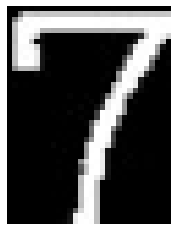

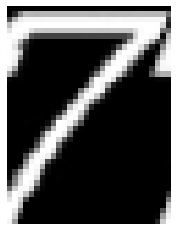

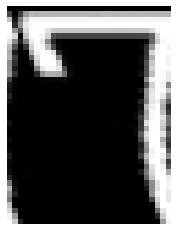

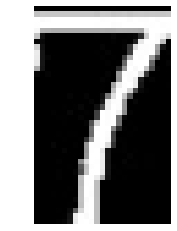

In [31]:

image = cv2.imread("model/dataSet/trainData/7/7C0.jpg", cv2.COLOR_BGR2GRAY)
showImage(image)

img = image

# image = rotate(img, angle=-45,cval=1); 
# showImage(image)
# image = rotate(img, angle=45,cval=1); 
# showImage(image)
image = transform.warp(img, AffineTransform(shear=-0.4), order=1, preserve_range=True, mode='wrap');
showImage(image)
image = transform.warp(img, AffineTransform(shear=0.4), order=1, preserve_range=True, mode='wrap'); 
showImage(image)
# #----------------------------------------------------------------
image = img.copy();
image[:, 0:5] = 0
showImage(image)



In [62]:
# Image Augmentation, referncee: https://www.codespeedy.com/image-augmentation-using-skimage-in-python/

import random 


def augmentImage(img):
    # original image
    augmentedImages=[img.flatten()]
    augmentedImages.append(img.flatten()) # add the image multiple times
    augmentedImages.append(img.flatten()) # add the image multiple times
    augmentedImages.append(img.flatten()) # add the image multiple times
    # rotation by i
    for i in range(1, 8):
        randomNum = random.randint(-5,5)
        image = rotate(img, angle=i*20 + randomNum, cval=1); augmentedImages.append(image.flatten())
        image = rotate(img, angle=-i*20 + randomNum, cval=1); augmentedImages.append(image.flatten())
    # Shearing
    image = transform.warp(img, AffineTransform(shear=-0.4), order=1, preserve_range=True, mode='wrap'); augmentedImages.append(image.flatten())
    image = transform.warp(img, AffineTransform(shear=0.4), order=1, preserve_range=True, mode='wrap'); augmentedImages.append(image.flatten())
    # Cropping by 7
    image = img.copy(); image[:, 23:] = 0; augmentedImages.append(image.flatten())
    image = img.copy(); image[:, 0:7] = 0; augmentedImages.append(image.flatten())
    image = img.copy(); image[0:7,:] = 0; augmentedImages.append(image.flatten())
    image = img.copy(); image[33:, :] = 0; augmentedImages.append(image.flatten())
    # Cropping by 10
    image = img.copy(); image[:, 20:] = 0; augmentedImages.append(image.flatten())
    image = img.copy(); image[:, 0:10] = 0; augmentedImages.append(image.flatten())
    image = img.copy(); image[0:10,:] = 0; augmentedImages.append(image.flatten())
    image = img.copy(); image[30:, :] = 0; augmentedImages.append(image.flatten())
    # inverse
    image = 1 - img.copy(); augmentedImages.append(image.flatten())

    
    return augmentedImages
    
    


# Import and split the data

In [64]:
import os
trainData = []
trainLabels = []

dire="model/DataSet/trainData" 

classes = os.listdir(dire)
print(len(classes))

numClassesWithLimit = 0
LIMIT = 100000 # to have the same number of items in all classes
for innerDir in os.listdir(dire):
    count = 0
    for filename in os.listdir(dire+'/' +innerDir):
        # read image
        image = cv2.imread(dire+'/' + innerDir +'/' +filename, cv2.COLOR_BGR2GRAY)/255.0

        # augmentImage
        augmentedImages = augmentImage(image.copy())
        count +=  len(augmentedImages)

        # append images
        trainData+=augmentedImages
        trainLabels+=[innerDir] * len(augmentedImages)

        # to break the inner loop if the number of items in the class exceeded the LIMIT
        if (count >= LIMIT):
            numClassesWithLimit+=1
            print("Class", innerDir , "has", count, "items")
            break

print("Number of classes that have exceeded", LIMIT, "items is:", numClassesWithLimit, "out of", len(os.listdir(dire)))
print("trainData Size:", len(trainData), "and trainLabels size:", len(trainLabels))



17
Number of classes that have exceeded 100000 items is: 0 out of 17
trainData Size: 124990 and trainLabels size: 124990


In [65]:
from sklearn.model_selection import train_test_split

# split the data
trainData, testData, trainLabels, testLabels = train_test_split(trainData, trainLabels, test_size = 0.01 , random_state=50)


# Trainning

In [66]:
model_KNN = KNeighborsClassifier(n_neighbors=17, weights='distance',n_jobs=-1) 
model_KNN.fit(trainData, trainLabels)

KNeighborsClassifier(n_jobs=-1, n_neighbors=17, weights='distance')

In [36]:
# from sklearn.svm import LinearSVC
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler

# model_SVC = make_pipeline(StandardScaler(), LinearSVC(random_state=0, tol=1e-5, max_iter=1e5))
# # model_SVC = svm.SVC(gamma=.001,C=100)
# model_SVC.fit(trainData, trainLabels)

# Save the model

In [67]:
from joblib import dump, load
# save the model
# dump(model_SVC, 'SVC_model.joblib') 
dump(model_KNN, 'model/KNN_model.joblib') 

# load the model
model = load('model/KNN_model.joblib')
model_SVC = load('model/SVC_model.joblib')

# model = model_KNN

# Evaluate the model

In [38]:
# from sklearn.metrics import accuracy_score

# # KNN
# Labels_KNN_pred = model.predict(testData) 
# print("KNN Model Accuarcy", accuracy_score(testLabels, Labels_KNN_pred)) # validate the model

In [39]:
# from sklearn.metrics import accuracy_score

# # SVM
# Labels_SVM_pred = model_SVC.predict(testData) # test -predict the test trainData-
# print("SVM Model Accuarcy", accuracy_score(testLabels, Labels_SVM_pred)) # validate the model

# Random TestCases

In [68]:
import random 

count  = 0
LIMIT = 10
for i in range(LIMIT):
    randomIndex = random.randint(0,len(testLabels))

    # prediction
    prediction = model.predict([testData[randomIndex]])
    probabilities = model.predict_proba([testData[randomIndex]])[0]
    classIndex =  np.where(model.classes_ == prediction)[0]
    print("Predicted", testLabels[randomIndex], "as", prediction[0],
         "With probability", probabilities[classIndex][0])
    #
    if (testLabels[randomIndex] == model.predict([testData[randomIndex]])[0]):
        count += 1
print(count, "Passed out of", LIMIT)


Predicted spade as spade With probability 0.5960092385229554
1 Passed out of 1


# Test Data

In [42]:
import os

dire="Grouping/imgs/"
print("Number of test images", len(os.listdir(dire)))
for filename in os.listdir(dire):
    image = cv2.imread(dire+filename, cv2.COLOR_BGR2GRAY)/255.0
    # print(image.shape)
    prediction = model.predict([image.flatten()])
    probabilities = model.predict_proba([image.flatten()])[0]
    classIndex =  np.where(model.classes_ == prediction)[0]
    if (probabilities[classIndex] < 0.8):
        print("Failed to detect the symbol")
    else:
        print("Predicted as", prediction[0],
            "With probability", probabilities[classIndex])
    showImage(image)

Number of test images 138


ValueError: X has 900 features, but KNeighborsClassifier is expecting 1200 features as input.

Predicted as J With probability [1.]


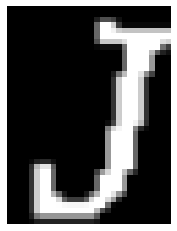

Predicted as 2 With probability [0.57894431]


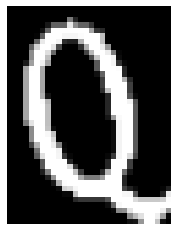

Predicted as diamond With probability [1.]


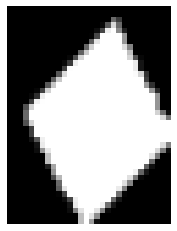

Predicted as diamond With probability [1.]


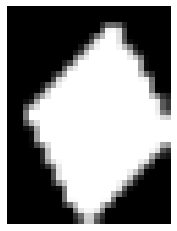

Predicted as spade With probability [1.]


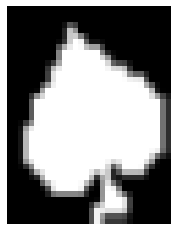

Predicted as spade With probability [0.59436279]


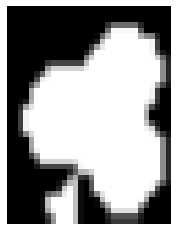

Predicted as spade With probability [0.82307952]


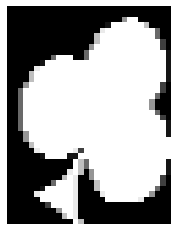

Predicted as spade With probability [0.52283596]


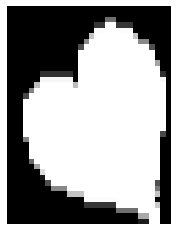

Predicted as 7 With probability [0.38790403]


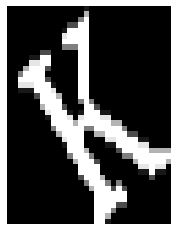

Predicted as spade With probability [0.94052312]


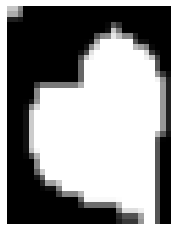

Predicted as club With probability [0.52978411]


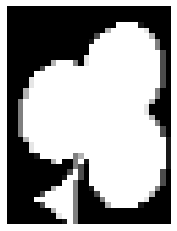

Predicted as spade With probability [0.81831391]


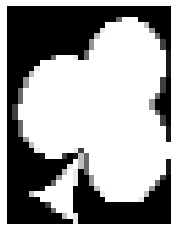

Predicted as club With probability [0.64783389]


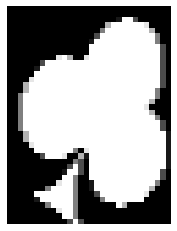

Predicted as spade With probability [0.52766427]


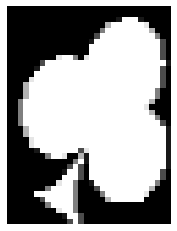

Predicted as spade With probability [0.65883932]


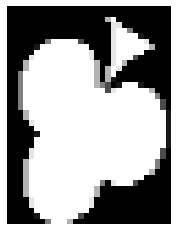

Predicted as A With probability [1.]


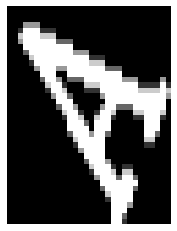

Predicted as spade With probability [0.88453128]


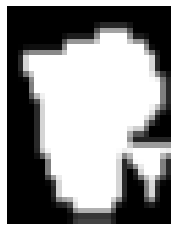

Predicted as spade With probability [0.59397644]


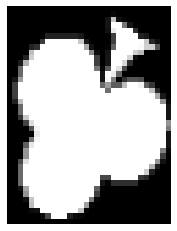

Predicted as spade With probability [0.70554387]


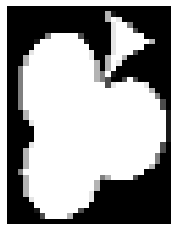

Predicted as spade With probability [0.59791106]


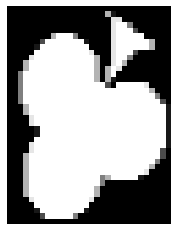

Predicted as spade With probability [0.65543317]


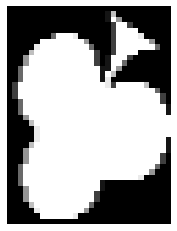

Predicted as diamond With probability [0.69924684]


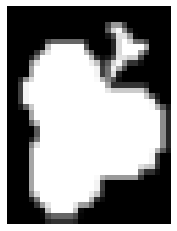

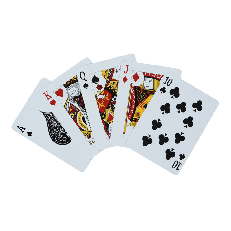

Cards are: {('7', 'S'), ('J', 'D'), ('2', 'S'), ('A', 'S')}
Total Number of Cards: 4


In [61]:
import skimage.io as io
import skimage.io as io
import utilities
from utilities import getSymboles
# from utilities import getGreyImage
from utilities import predict
from utilities import classification_mapping
from utilities import grouping
from utilities import ApplyOnImage

import os
import sys
from matplotlib import pyplot as plt
from skimage.color import rgb2gray
from skimage import data, io, filters, feature, measure, transform, morphology
import matplotlib.pylab as plt
import numpy as np
import skimage
import skimage.exposure
import skimage.feature
import skimage.filters
import skimage.io as io
import skimage.morphology
import skimage.transform
from joblib import load
from skimage import transform, util
from skimage.filters import gaussian, threshold_otsu
from skimage.transform import AffineTransform, rotate, warp
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
import cv2


def predict(image, modelPath='model/KNN_model.joblib'):
    # load the model
    model = load(modelPath)
    prediction =  model.predict([image.flatten()])[0]
    probabilities = model.predict_proba([image.flatten()])[0]
    classIndex =  np.where(model.classes_ == prediction)[0]

    return prediction, probabilities[classIndex]

def getGreyImage(image):
    image = image.astype(float)
    R = image[:, :, 0]
    G = image[:, :, 1]
    B = image[:, :, 2]
    mask = (R - G > 70) & (R - B > 70)
    R[mask] = 0
    return rgb2gray(image).astype(float)


path="Grouping/cards6.jpg"
image = io.imread(path)
# io.imshow(image)
# io.show()
if len(image.shape) == 2:
    greyImage = image
else:
    greyImage = getGreyImage(image)/255.0

symbolesList = getSymboles(greyImage)
features = []
for symbol in symbolesList:
    prediction, prob = predict(symbol[0])
    if (prob > 0.0):
        print("Predicted as", prediction,
            "With probability", prob); showImage(symbol[0])
        prediction = classification_mapping(prediction)
        features.append((prediction, symbol[1], symbol[2]))
showImage(io.imread(path,as_gray=False))
cards = grouping(features)
print("Cards are:", cards)
print("Total Number of Cards:", len(cards))